<a href="https://colab.research.google.com/github/pranavananthram/Plant-classifier-Computer-vision/blob/main/plantclassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# =========================================================
# 1️⃣ INSTALL DEPENDENCIES
# =========================================================
# Uncomment if not already installed
!pip install kaggle kagglehub torch torchvision torchaudio albumentations opencv-python scikit-learn matplotlib seaborn gradio


# =========================================================
# 2️⃣ IMPORTS
# =========================================================
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import torch.nn as nn
import torch.optim as optim
from pathlib import Path
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import gradio as gr
import shutil
from sklearn.model_selection import train_test_split
import os


# =========================================================
# 3️⃣ DOWNLOAD DATASET
# =========================================================
import kagglehub
dataset_path = kagglehub.dataset_download("vipoooool/new-plant-diseases-dataset")
print("Dataset cached at:", dataset_path)


# =========================================================
# 4️⃣ EXPLORE AND FIND CORRECT PATHS
# =========================================================
def explore_directory(path, max_depth=3, current_depth=0):
    """Recursively explore directory structure"""
    path = Path(path)
    if current_depth >= max_depth:
        return

    try:
        for item in path.iterdir():
            print("  " * current_depth + str(item))
            if item.is_dir():
                explore_directory(item, max_depth, current_depth + 1)
    except PermissionError:
        print("  " * current_depth + "[Permission Denied]")

print("\n📂 Exploring dataset structure:")
explore_directory(dataset_path, max_depth=3)


# =========================================================
# 5️⃣ FIND ACTUAL TRAIN DIRECTORY
# =========================================================
def find_train_dir(base_path):
    """Find the actual train directory in the dataset"""
    base_path = Path(base_path)

    # Common possible paths
    possible_paths = [
        base_path / "train",
        base_path / "New Plant Diseases Dataset(Augmented)" / "train",
        base_path / "new plant diseases dataset(augmented)" / "train",
    ]

    # Also search recursively
    for root, dirs, files in os.walk(base_path):
        if "train" in dirs:
            possible_paths.append(Path(root) / "train")

    # Return the first existing path
    for path in possible_paths:
        if path.exists() and path.is_dir():
            print(f"✅ Found train directory: {path}")
            return path

    return None

train_source = find_train_dir(dataset_path)

if train_source is None:
    raise FileNotFoundError(f"Could not find train directory in {dataset_path}")


# =========================================================
# 6️⃣ CREATE TRAIN/VAL/TEST SPLITS
# =========================================================
# Destination folders (writable)
base_dir = Path("/content/plantvillage")
train_dir = base_dir / "train"
val_dir   = base_dir / "val"
test_dir  = base_dir / "test"

# Clear old splits
for d in [train_dir, val_dir, test_dir]:
    if d.exists():
        shutil.rmtree(d)
    d.mkdir(parents=True, exist_ok=True)

# Split each class
print("\n📊 Splitting dataset...")
for cls_folder in train_source.iterdir():
    if not cls_folder.is_dir():
        continue

    images = list(cls_folder.glob("*.jpg")) + list(cls_folder.glob("*.jpeg")) + list(cls_folder.glob("*.png")) + list(cls_folder.glob("*.JPG"))

    if len(images) < 2:
        print(f"⚠️ Skipping class {cls_folder.name} (only {len(images)} image(s))")
        continue

    print(f"Processing {cls_folder.name}: {len(images)} images")

    train_imgs, temp_imgs = train_test_split(images, test_size=0.3, random_state=42)
    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.5, random_state=42)

    # Copy images to writable train/val/test
    for img in train_imgs:
        (train_dir / cls_folder.name).mkdir(parents=True, exist_ok=True)
        shutil.copy(img, train_dir / cls_folder.name / img.name)
    for img in val_imgs:
        (val_dir / cls_folder.name).mkdir(parents=True, exist_ok=True)
        shutil.copy(img, val_dir / cls_folder.name / img.name)
    for img in test_imgs:
        (test_dir / cls_folder.name).mkdir(parents=True, exist_ok=True)
        shutil.copy(img, test_dir / cls_folder.name / img.name)

print("✅ Dataset split complete!")


Using Colab cache for faster access to the 'new-plant-diseases-dataset' dataset.
Dataset cached at: /kaggle/input/new-plant-diseases-dataset

📂 Exploring dataset structure:
/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)
  /kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)
    /kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid
    /kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train
/kaggle/input/new-plant-diseases-dataset/new plant diseases dataset(augmented)
  /kaggle/input/new-plant-diseases-dataset/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)
    /kaggle/input/new-plant-diseases-dataset/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid
    /kaggle/input/new-plant-diseases-dataset/new p


📋 Number of classes: 38
Train samples: 49190
Val samples: 10541
Test samples: 10564

🖥️ Using device: cuda
Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 155MB/s]


✅ Model created with 38 output classes

🚀 Starting training...
Epoch 1/10 | Train Loss: 1.2124 | Train Acc: 0.7106 | Val Loss: 0.4770 | Val Acc: 0.8749 | Time: 261.5s
💾 Saved best model (val_loss: 0.4770)
Epoch 2/10 | Train Loss: 0.7261 | Train Acc: 0.7955 | Val Loss: 0.3373 | Val Acc: 0.9109 | Time: 257.6s
💾 Saved best model (val_loss: 0.3373)
Epoch 3/10 | Train Loss: 0.6564 | Train Acc: 0.8086 | Val Loss: 0.3199 | Val Acc: 0.9078 | Time: 261.6s
💾 Saved best model (val_loss: 0.3199)
Epoch 4/10 | Train Loss: 0.6225 | Train Acc: 0.8124 | Val Loss: 0.2745 | Val Acc: 0.9208 | Time: 255.0s
💾 Saved best model (val_loss: 0.2745)
Epoch 5/10 | Train Loss: 0.6006 | Train Acc: 0.8189 | Val Loss: 0.2680 | Val Acc: 0.9195 | Time: 260.0s
💾 Saved best model (val_loss: 0.2680)
Epoch 6/10 | Train Loss: 0.5931 | Train Acc: 0.8209 | Val Loss: 0.2639 | Val Acc: 0.9175 | Time: 253.8s
💾 Saved best model (val_loss: 0.2639)
Epoch 7/10 | Train Loss: 0.5919 | Train Acc: 0.8191 | Val Loss: 0.2439 | Val Acc: 0.9

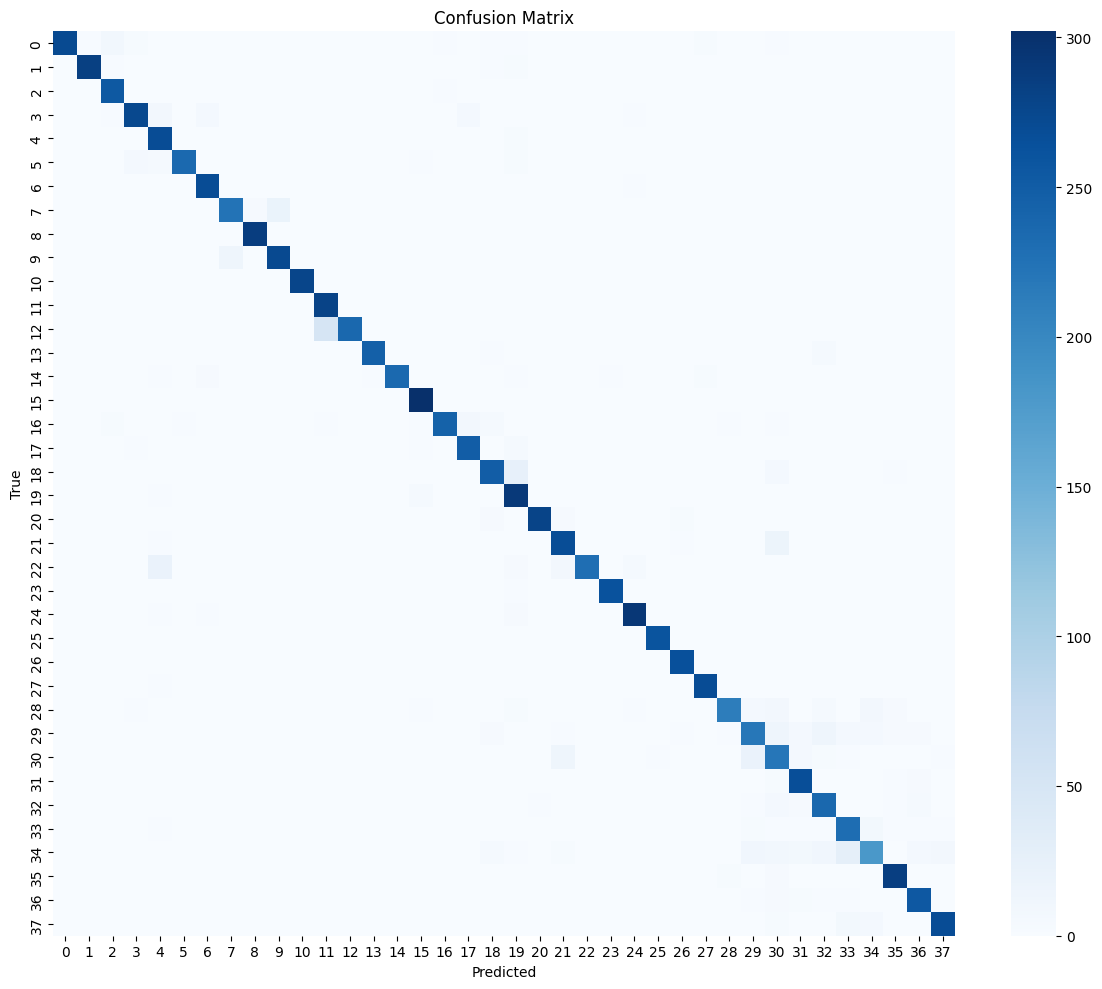

In [ ]:

# =========================================================
# 7️⃣ CREATE DATA LOADERS
# =========================================================
input_size = 224

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(input_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(25),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((input_size,input_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225])
])

train_ds = datasets.ImageFolder(train_dir, transform=train_transform)
val_ds   = datasets.ImageFolder(val_dir, transform=test_transform)
test_ds  = datasets.ImageFolder(test_dir, transform=test_transform)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_ds, batch_size=32, shuffle=False, num_workers=2)

print(f"\n📋 Number of classes: {len(train_ds.classes)}")
print(f"Train samples: {len(train_ds)}")
print(f"Val samples: {len(val_ds)}")
print(f"Test samples: {len(test_ds)}")


# =========================================================
# 8️⃣ SET DEVICE (GPU if available)
# =========================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\n🖥️ Using device: {device}")


# =========================================================
# 9️⃣ CREATE MOBILENETV2 MODEL
# =========================================================
num_classes = len(train_ds.classes)

model = models.mobilenet_v2(weights="DEFAULT")

# Freeze pretrained layers
for param in model.parameters():
    param.requires_grad = False

# Replace classifier
in_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(in_features, num_classes)

model = model.to(device)
print(f"✅ Model created with {num_classes} output classes")


# =========================================================
# 🔟 LOSS, OPTIMIZER, LR SCHEDULER
# =========================================================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.1)



# =========================================================
# 1️⃣1️⃣ TRAINING LOOP
# =========================================================
import time

def train_model(epochs=10):
    best_loss = float("inf")
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(epochs):
        t0 = time.time()

        # --- Training ---
        model.train()
        train_loss, correct, total = 0, 0, 0
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(X)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * X.size(0)
            _, pred = torch.max(out, 1)
            correct += (pred == y).sum().item()
            total += X.size(0)

        train_loss /= total
        train_acc = correct / total

        # --- Validation ---
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                out = model(X)
                loss = criterion(out, y)

                val_loss += loss.item() * X.size(0)
                _, pred = torch.max(out, 1)
                val_correct += (pred == y).sum().item()
                val_total += X.size(0)

        val_loss /= val_total
        val_acc = val_correct / val_total

        scheduler.step(val_loss)

        # Store history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Time: {time.time()-t0:.1f}s")

        # Save best model
        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), "mobilenetv2_plant.pth")
            print(f"💾 Saved best model (val_loss: {val_loss:.4f})")

    return history

print("\n🚀 Starting training...")
history = train_model(epochs=10)


# =========================================================
# 1️⃣2️⃣ EVALUATION
# =========================================================
print("\n📊 Evaluating on test set...")
model.load_state_dict(torch.load("mobilenetv2_plant.pth"))
model.eval()

all_preds, all_labels = [], []

with torch.no_grad():
    for X, y in test_loader:
        X = X.to(device)
        out = model(X)
        _, preds = torch.max(out, 1)
        all_preds.append(preds.cpu().numpy())
        all_labels.append(y.numpy())

all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

print("\n" + "="*50)
print("CLASSIFICATION REPORT")
print("="*50)
print(classification_report(all_labels, all_preds, target_names=train_ds.classes))


# =========================================================
# 1️⃣3️⃣ CONFUSION MATRIX
# =========================================================
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=False, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


# =========================================================
# 1️⃣4️⃣ GRADIO DEMO
# =========================================================
#def predict(img):
 #   """Predict plant disease from image"""
  #  model.eval()
   # x = test_transform(img).unsqueeze(0).to(device)
    #with torch.no_grad():
     #   out = model(x)
      #  probs = torch.nn.functional.softmax(out, dim=1)
       # _, pred = torch.max(out, 1)

   # predicted_class = train_ds.classes[pred.item()]
    #confidence = probs[0][pred.item()].item()

    #return f"{predicted_class} (Confidence: {confidence:.2%})"

#demo = gr.Interface(
 #   fn=predict,
  #  inputs=gr.Image(type="pil"),
   # outputs="text",
    #title="🌿 Plant Disease Classifier",
    #description="Upload an image of a plant leaf to identify diseases"
#)

#demo.launch()

In [ ]:
# =========================================================
# 1️⃣4️⃣ GRADIO DEMO
# =========================================================
def predict(img):
    """Predict plant disease from image"""
    model.eval()
    x = test_transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        out = model(x)
        probs = torch.nn.functional.softmax(out, dim=1)
        _, pred = torch.max(out, 1)

    predicted_class = train_ds.classes[pred.item()]
    confidence = probs[0][pred.item()].item()

    return f"{predicted_class} (Confidence: {confidence:.2%})"

demo = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil"),
    outputs="text",
    title="🌿 Plant Disease Classifier",
    description="Upload an image of a plant leaf to identify diseases"
)

demo.launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://136871342588e8fc30.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
